
The Flywing dataset is composed of a sibngle 3D fluorescence microscopy stack. Here, we 
demonstrate the performances of Noise2Void on this particular dataset!

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils import autocorrelation
from careamics_portfolio import PortfolioManager
from PIL import Image

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [2]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
file = portfolio.denoising.Flywing.download(root_path)

## Visualize data

Image shape: (35, 520, 692)


Text(0.5, 1.0, 'Slice 30')

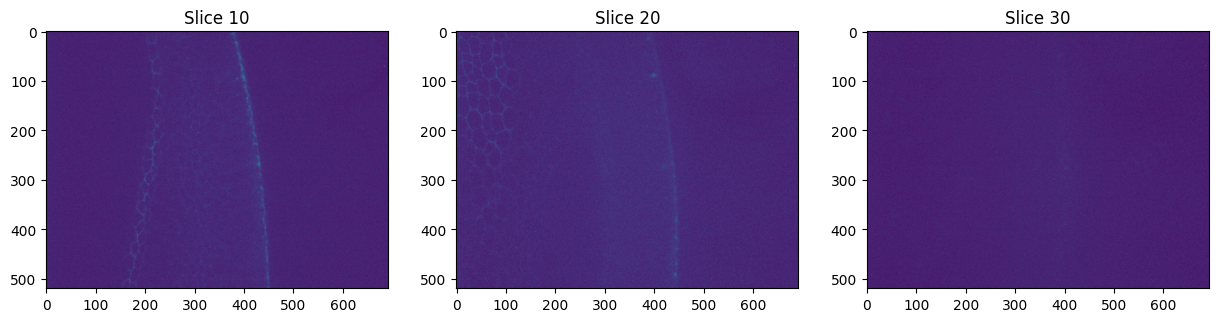

In [3]:
# load stack
train_image = tifffile.imread(file[0])
print(f"Image shape: {train_image.shape}")

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(train_image[10])
ax[0].set_title("Slice 10")
ax[1].imshow(train_image[20])
ax[1].set_title("Slice 20")
ax[2].imshow(train_image[30])
ax[2].set_title("Slice 30")

### Compute autocorrelation

Text(0.5, 1.0, 'Autocorrelation')

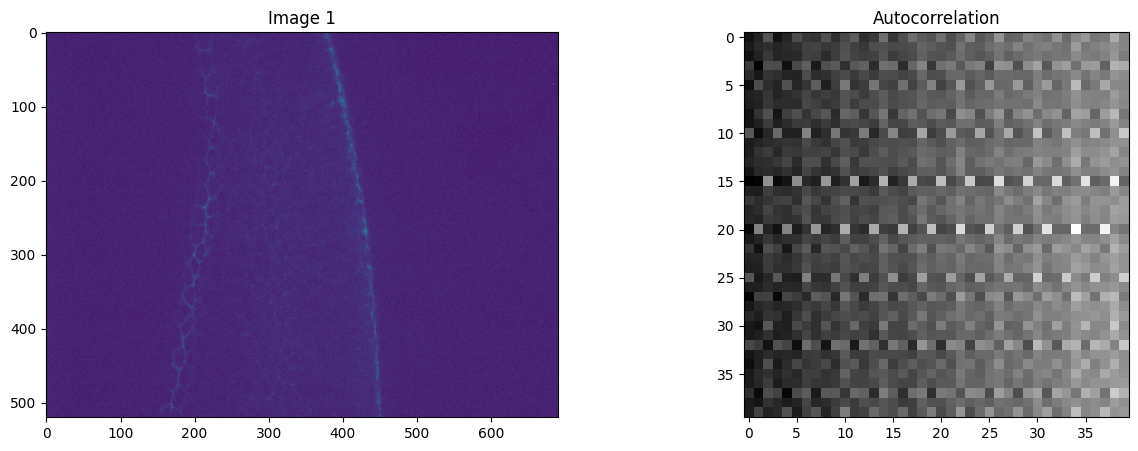

In [21]:
slice_idx = 10
autocorr = autocorrelation(train_image[slice_idx])

# crop the correlation around (0, 0)
midpoint = train_image[slice_idx].shape[0] // 2
crop_size = 20
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)
# plot autocorrelation
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(train_image[slice_idx])
ax[0].set_title("Image 1")
ax[1].imshow(autocorr[slices], cmap="gray")
ax[1].set_title("Autocorrelation")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [5]:
config = create_n2v_configuration(
    experiment_name="flywing_n2v",
    data_type="array",
    axes="ZYX",
    patch_size=(16, 64, 64),
    batch_size=2,
    num_epochs=1,
    use_augmentations=False,  # remove augmentations
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 3,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'ZYX',
                 'batch_size': 2,
                 'data_type': 'array',
                 'patch_size': [16, 64, 64],
                 'transforms': [{'masked_pixel_per

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [6]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
    val_percentage=0.0,
    val_minimum_split=10,  # use 10 patches as validation
)

No working directory provided. Using current working directory: /Users/joran.deschamps/git/careamics/careamics-examples/applications/n2v/3D.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Computed dataset mean: [36.833492], std: [5.2682214]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 1.5 M 
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `float` but got `float32` - serialized value may not be as expected
  Expected `float` but got `float32` - serialized value may not be as expected
  return self.__pydan

Epoch 0: 100%|██████████| 144/144 [04:15<00:00,  1.77s/it, train_loss_step=0.979, val_loss=0.847, train_loss_epoch=0.867]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 144/144 [04:15<00:00,  1.77s/it, train_loss_step=0.979, val_loss=0.847, train_loss_epoch=0.867]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [7]:
prediction = careamist.predict(
    source=train_image,
    tile_size=(32, 128, 128),
    tile_overlap=(8, 48, 48),
    batch_size=1,
    tta=False,
)

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Save predictions

In [8]:
pred_folder = Path("results_n2v")
pred_folder.mkdir(exist_ok=True, parents=True)

tifffile.imwrite(pred_folder / "prediction.tiff", prediction[0])

### Visualize the prediction

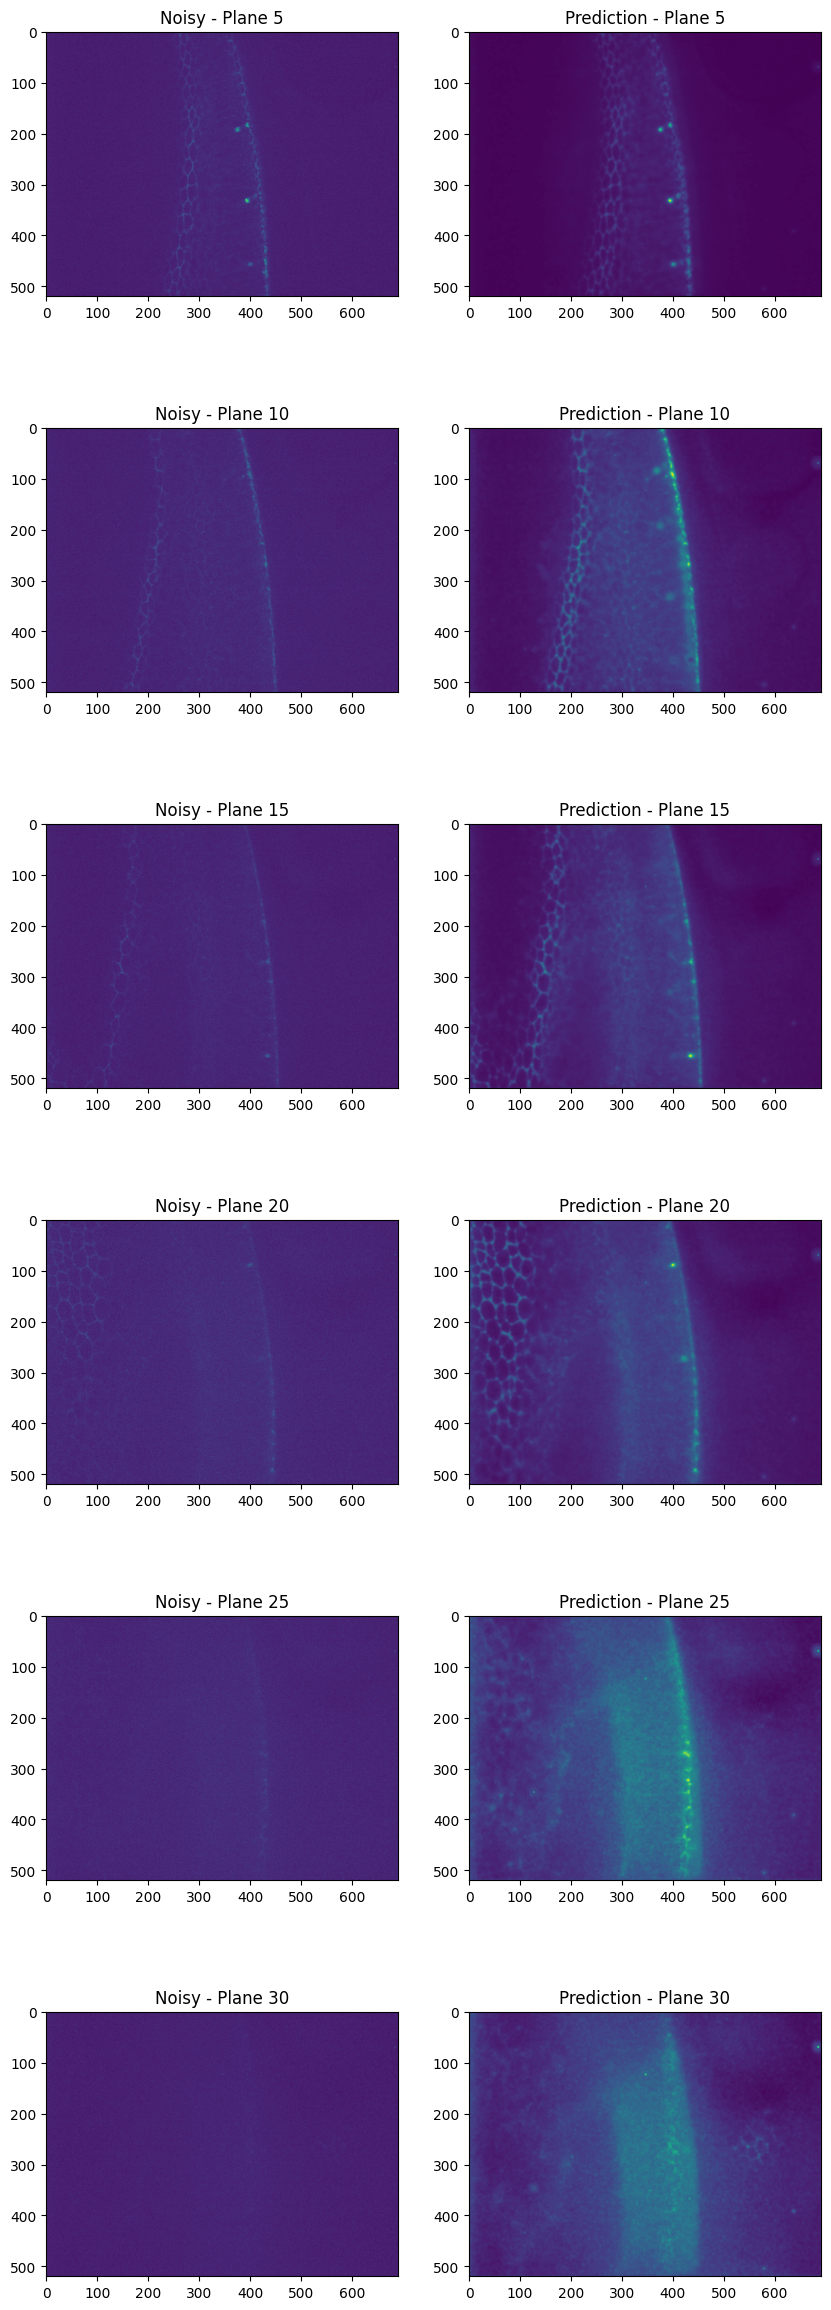

In [9]:
# Show multiple slices
zs = [5, 10, 15, 20, 25, 30]

fig, ax = plt.subplots(len(zs), 2, figsize=(10, 5 * len(zs)))
for i, z in enumerate(zs):
    ax[i, 0].imshow(train_image[z])
    ax[i, 0].set_title(f"Noisy - Plane {z}")

    ax[i, 1].imshow(prediction[0].squeeze()[z])
    ax[i, 1].set_title(f"Prediction - Plane {z}")

## Create cover

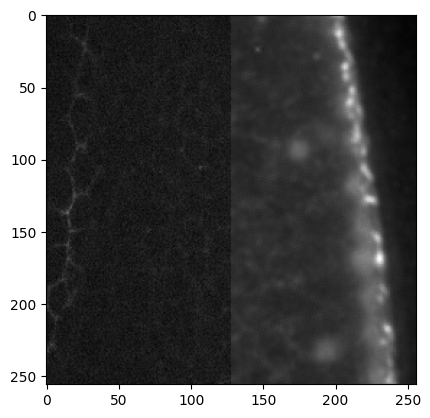

In [19]:
# create a cover image
im_idx = 10
x_min = 200
y_min = 100

cv_image_noisy = train_image[im_idx]
cv_image_pred = prediction[0].squeeze()[im_idx]

# create image
cover = np.zeros((256, 256))
(height, width) = cv_image_noisy.shape
assert height > 256
assert width > 256
assert y_min + 256 < height
assert x_min + 256 < width

# normalize train and prediction
norm_noise = (cv_image_noisy - cv_image_noisy.min()) / (
    cv_image_noisy.max() - cv_image_noisy.min()
)
norm_pred = (cv_image_pred - cv_image_pred.min()) / (
    cv_image_pred.max() - cv_image_pred.min()
)

# fill in halves
cover[:, : 256 // 2] = norm_noise[y_min : y_min + 256, x_min : x_min + 256 // 2]
cover[:, 256 // 2 :] = norm_pred[y_min : y_min + 256, x_min + 256 // 2 : x_min + 256]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("SUPPORT_N2V.jpeg")